# Applied Data Analysis — Homework 4

Import common libraries

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data and display a sample. The latter is just for ensuring that the data could be read; all columns are not shown as they are already explained in the recommended reading, as well as in the provided `DATA.md` file.

In [43]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv', parse_dates=['birthday'])
df.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
8935,john-arne-riise,John Arne Riise,Fulham FC,England,1980-09-24,185.0,77.0,Left Fullback,2,1,...,0.00,204,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
85002,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,1984-01-26,177.0,74.0,Right Fullback,1,0,...,0.00,1852,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
60312,sebastian-kehl,Sebastian Kehl,Borussia Dortmund,Germany,1980-02-13,188.0,80.0,Defensive Midfielder,2,1,...,0.00,1221,45,SCOT,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
112895,andrew-surman,Andrew Surman,Norwich City,England,1986-08-20,178.0,72.0,Attacking Midfielder,2,0,...,NaN,2389,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
103759,manuel-neuer,Manuel Neuer,Bayern München,Germany,1986-03-27,193.0,92.0,Goalkeeper,3,1,...,0.25,2230,72,PRT,0.396803,1079.0,0.000392,0.790366,1121.0,0.001798


Just out of curiosity, which is the player with the most interactions with a referee?

In [44]:
df.sort_values('games', ascending=False)[:5]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
48893,philipp-lahm,Philipp Lahm,Bayern München,Germany,1983-11-11,170.0,66.0,Left Fullback,47,29,...,0.25,933,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
48390,bastian-schweinsteiger,Bastian Schweinsteiger,Bayern München,Germany,1984-01-08,183.0,79.0,Defensive Midfielder,46,28,...,0.25,933,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
54811,paul-scholes,Paul Scholes,Manchester United,England,1974-11-16,170.0,72.0,Center Midfielder,44,28,...,0.00,1095,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
97628,frank-lampard,Frank Lampard,Chelsea FC,England,1978-06-20,183.0,77.0,Center Midfielder,44,29,...,0.25,2080,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
59844,michael-carrick,Michael Carrick,Manchester United,England,1981-07-28,186.0,74.0,Center Midfielder,42,24,...,0.00,1214,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037


## Cleaning the data

As is described in the recommended reading, all games for each player are included.
This is evident in the 47 games Philipp Lahm played under a single referee — a feat that could not be archieved in the Bundesliga, which has less games per team per season.

This results in a lot of noise.
As done in the recommended reading, we therefore remove all dyads (player-referee pairs) for referees that do not have connections to at least 22 players, the minimum for a single game.

In [45]:
df_ref_group_sizes = df.groupby('refNum').size()
# Referees that have at least 22 associated players
good_df_refs = df_ref_group_sizes[df_ref_group_sizes >= 22]

df = df[df['refNum'].isin(good_df_refs.index.values)]

Just to be sure, verify that the new minimum is actually 22:

In [46]:
df.groupby('refNum').size().min()

22

The classifier only supports dealing with numbers, so we convert the birthdate to an int:

In [47]:
df['birthday'] = df['birthday'].astype('int64')

df['birthday'].sample(5)

20931     489628800000000000
37641     283737600000000000
137625    573091200000000000
105512    488073600000000000
101803    313977600000000000
Name: birthday, dtype: int64

Let's check whether one of the two raters has a tendency to rate lower than the other:

In [48]:
rating_differences = (df['rater2'] - df['rater1']).abs()

rating_differences.mean()

0.05836231578577576

With a fifth of a step, this does not seem substantial.
Let's check how often they actually disagree substantially (using half of the available scale):

In [49]:
rating_differences[rating_differences >= .5].count()

163

Given the small count, we should be fine with ignoring them.

Next, we create a new column that merges the two skin tone ratings.

In [50]:
df['skinRating'] = (df['rater1'] + df['rater2']) / 2

df.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinRating
133509,etienne-capoue,Étienne Capoue,Toulouse FC,France,594864000000000000,189.0,75.0,Defensive Midfielder,1,0,...,2835,71,NOR,0.340606,4949.0,0.000083,0.692824,5212.0,0.000391,NaN
71361,paco-montanes,Paco Montañés,Real Zaragoza,Spain,524016000000000000,172.0,70.0,NaN,3,1,...,1536,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.25
44636,movilla,Movilla,Real Zaragoza,Spain,176169600000000000,171.0,70.0,Defensive Midfielder,1,1,...,829,50,MKD,0.327139,170.0,0.002362,0.959538,173.0,0.014794,0.25
37477,chris-martin,Chris Martin,Swindon Town,England,576720000000000000,178.0,73.0,Center Forward,6,1,...,669,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,NaN
90812,yohan-cabaye,Yohan Cabaye,Newcastle United,England,506044800000000000,175.0,69.0,Defensive Midfielder,1,1,...,1946,40,SWE,0.340205,5223.0,0.000081,0.626401,5621.0,0.000373,0.00


At this point, we do not remove further values.
The intuition is that even missing values might have a relation to the skin color.

## Task 1

> Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

#### From dyads to player stats

First, we need to get per-player stats from the dyads.
We do this by aggregating all statistics.

To know what we're dealing with, we print a list of all data types:

In [52]:
df.dtypes

playerShort       object
player            object
club              object
leagueCountry     object
birthday           int64
height           float64
weight           float64
position          object
games              int64
victories          int64
ties               int64
defeats            int64
goals              int64
yellowCards        int64
yellowReds         int64
redCards           int64
photoID           object
rater1           float64
rater2           float64
refNum             int64
refCountry         int64
Alpha_3           object
meanIAT          float64
nIAT             float64
seIAT            float64
meanExp          float64
nExp             float64
seExp            float64
skinRating       float64
dtype: object

Based on this, we aggregate stats for all players:

In [53]:
def most_common(val):
    val_counts = val.value_counts()
    if val_counts.size > 0:
        return val_counts.keys()[0]

player_df = df.groupby('playerShort').agg({
    'club': most_common,
    'leagueCountry': most_common,
    'position': most_common,
        
    'birthday': 'max', # Use the highest age

    'height': 'mean',
    'weight': 'mean',
    'meanIAT': 'mean',
    'nIAT': 'mean',
    'seIAT': 'mean',
    'meanExp': 'mean',
    'nExp': 'mean',
    'seExp': 'mean',
    'skinRating': 'mean',
        
    'games': 'sum',
    'victories': 'sum',
    'ties': 'sum',
    'defeats': 'sum',
    'goals': 'sum',
    'yellowCards': 'sum',
    'yellowReds': 'sum',
    'redCards': 'sum',
})

player_df.reset_index() # get the df back from groupby

player_df.sample(5)

,club,skinRating,position,seIAT,yellowReds,yellowCards,goals,seExp,games,height,...,meanIAT,leagueCountry,defeats,meanExp,redCards,nExp,ties,victories,nIAT,weight
playerShort,,,,,,,,,,,,,,,,,,,,,
borja-gomez,Granada CF,0.00,None,0.000323,2,21,4,0.001514,72,184.0,...,0.370805,Spain,31,0.625081,0,1881.108696,14,27,1770.586957,77.0
luiz-gustavo,Bayern München,0.75,Defensive Midfielder,0.000543,6,63,13,0.003259,257,187.0,...,0.344258,Germany,55,0.433629,1,38913.102941,44,158,37823.794118,80.0
loris-karius,1. FSV Mainz 05,0.00,Goalkeeper,0.000055,0,1,0,0.000225,48,189.0,...,0.336628,Germany,18,0.335967,0,7974.000000,9,21,7749.000000,75.0
mario-mandzukic,Bayern München,0.25,Center Forward,0.000751,1,46,94,0.003216,233,187.0,...,0.352975,Germany,61,0.497626,1,6514.193548,42,130,6256.107527,84.0
fethi-harek,SC Bastia,NaN,None,0.000151,1,19,3,0.000586,152,175.0,...,0.334684,France,61,0.336101,0,3011.000000,37,54,2882.000000,61.0


`sklearn` chokes on undefined values.
Therefore, we first remove all players without a `skinRating`, as they cannot be classified.

In [59]:
total_player_number = player_df['skinRating'].size
ratingless_player_count = total_player_number - player_df['skinRating'].count()
print('Dropping ' + str(ratingless_player_count) + '/' + str(total_player_number) + ' players')

player_df.dropna(subset=['skinRating'], inplace=True)

player_df['skinRating'].size # display remaining to ensure it succeeded

Dropping 0/1584 players


1584

For the other values, let's fill them in with something unique, so these values can be classified properly.
We once again do not remove them as a missing value might represent a bias in the data gathering.

First, we display property counts.
Properties with lower counts have missing values.
As we have already filtered out players without a `skinRating`, we use that number as a baseline.

In [62]:
player_df.count() - player_df['skinRating'].count()

club              0
skinRating        0
position          0
seIAT             0
yellowReds        0
yellowCards       0
goals             0
seExp             0
games             0
height           -3
birthday          0
meanIAT           0
leagueCountry     0
defeats           0
meanExp           0
redCards          0
nExp              0
ties              0
victories         0
nIAT              0
weight          -21
dtype: int64

Only `position`, `weight` and `height` have missing entries.
As before, perhaps missing values have a significance, so let's fill them in with something unique.

In [61]:
player_df['position'].fillna('missing', inplace=True)
player_df['position'].count()

1584

In [63]:
# Neither weight nor height can be 0 under ordinary circumstances

player_df.fillna(0, inplace=True)
player_df.count() - player_df['skinRating'].count()

club             0
skinRating       0
position         0
seIAT            0
yellowReds       0
yellowCards      0
goals            0
seExp            0
games            0
height           0
birthday         0
meanIAT          0
leagueCountry    0
defeats          0
meanExp          0
redCards         0
nExp             0
ties             0
victories        0
nIAT             0
weight           0
dtype: int64

All cleaned up, so let's get to the interesting part:

__Note:__ The following is largely based on the [ensemble](http://scikit-learn.org/stable/modules/ensemble.html#forest) and [cross-validation guides](http://scikit-learn.org/stable/modules/cross_validation.html) from `scikit-learn`.

#### Preparing & split the test set

First, we have to convert string values to numbers to make them accessible to the classifier.
We are using dummies for that:

In [68]:
player_df_dummies = pd.get_dummies(player_df)

Next, we split the players to two sets, one for training, one for testing.
We use 2/5 of the dataset for testing.

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Needed for cross-validation

X = player_df_dummies.copy()
X.drop('skinRating', inplace=True, axis=1)

Y = LabelEncoder().fit_transform(player_df['skinRating'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.4, random_state=0)

All set, so let's use the classifier (with default parameters):

In [133]:
from sklearn.ensemble import RandomForestClassifier

def get_classifier(X_train, y_train, n_estimators=None, max_depth=None):
    classifier = RandomForestClassifier()
    return classifier.fit(X_train, y_train)

get_classifier(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### How well does the model perform?



In [90]:
from sklearn.model_selection import cross_val_score

def get_cross_val_scores(classifier, X_test, y_test):
    f1_score = np.mean(cross_val_score(classifier, X_test, y_test, scoring='f1_macro'))
    accuracy = np.mean(cross_val_score(classifier, X_test, y_test, scoring='accuracy'))
    
    return (f1_score, accuracy)

f1_score, accuracy = get_cross_val_scores(classifier, X_test, y_test)

'Accuracy score is ' + str(accuracy) + ', the F1-score is ' + str(f1_score)

/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'Accuracy score is 0.263600087043, the F1-score is 0.127393299358'

Interesting enough, some outcomes seem to be impossible to predict (see the warning).
Also, both our accuracy and our F1-score are abysmal, we should improve upon that.

Consequently, we simplify the problem:
From now on, we only distinguish between light and dark skin.

In [126]:
skin_ratings = player_df['skinRating'].map(lambda x: x > .5)
skin_ratings.sample(5)

playerShort
natxo-insa             False
ibrahima-traore         True
tranquillo-barnetta    False
siaka-tiene             True
johan-djourou           True
Name: skinRating, dtype: bool

What is actually the distribution of our values?
With `True` signifying dark-skinned players:

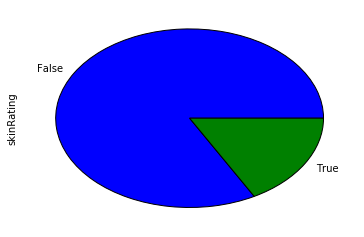

In [127]:
skin_ratings.value_counts().plot.pie()

As a percentage (using implicit casts from booleans to integers):

In [128]:
1 - skin_ratings.sum() / skin_ratings.size

0.83017676767676774

So whatever result we archieve has to better than this, otherwise always returning `False` (for light-skinned) would outperform our result.

In [134]:
Y = LabelEncoder().fit_transform(skin_ratings)

# note: we only use 1/5 of the values for the test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)

get_classifier(X_train, y_train)

f1_score, accuracy = get_cross_val_scores(classifier, X_test, y_test)

'Accuracy score is ' + str(accuracy) + ', the F1-score is ' + str(f1_score)

'Accuracy score is 0.854926624738, the F1-score is 0.580199429756'

That looks much better, although we only outperform a constant return value by a small margin.
Also, the F1-score is pretty low.
Let's try to improve upon that!

In [ ]:
def get_classifier_score(n_estimators, max_depth):
    classifier = get_classifier(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth)
    f1_score, accuracy = get_cross_val_scores(classifier, X_test, y_test)
    
    return (n_estimators, max_depth, f1_score, accuracy)

classifier_data = [
    get_classifier_score(n_estimators, max_depth)
    for n_estimators in range(1, 30) for max_depth in range(1, 30)
]

len(classifier_data)

/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/feedy/anaconda3/lib/p

In [ ]:
tree_options_df = pd.DataFrame.from_records(
    data=classifier_data,
    columns=['n_estimators', 'max_depth', 'f1_score', 'accuracy'],
    index=['n_estimators', 'max_depth']
)
tree_options_df.sample(5)

In [ ]:
tree_options_df.plot.line()

### Task 1 — Bonus

> Plot the learning curves against at least 2 different sets of parameters passed to your Random Forest.
To obtain smooth curves, partition your data in at least 20 folds.
Can you find a set of parameters that leads to high bias, and one which does not?

## Task 2

> Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters.
Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters?
Discuss the obtained results.